**Немного про бейзлайн. Основные проблемы**

В предложенном бейзлайне модель обучается по следующему пайплайну:

1. Производится EDA: рисуем гистограммы, приближающие функции распределения признаков
2. Агрегируем признаки и таргет по дате
3. Делим выборку на тренировочную и тестовую
4. Фитируем линейную регрессию на признаках, имеющих наибольшую корреляцию с таргетом
5. Измеряем R2 score модели

__Для начала хочется предложить исправление некоторых моментов в решении-бейзлайне.__


1. Мы агрегируем признаки и таргеты по дате измерения. Результирующая модель предсказывает среднее значение таргета среди всех измерений за сутки. С таким вариантом есть некоторые проблемы:

-  Скорее всего, by design мы хотим предсказывать средний LIQ_RATE за сутки. Либо за какой-то другой промежуток времени. Но наше правило агрегирования не учитывает момент, что время, когда производятся замеры таргета, может влиять на справедливую оценку таргета. Например, резонно утверждать, что если в 1 час ночи измерение было 0.0, а в 2 часа ночи 400.0, то средний результат за день скорее всего не 200.0, а что-то около 370.0 (мы не знаем, но такая оценка кажется **более правдоподобной**, учитывая особенности данных). Такой пример может быть найден в трейне - это 2 июня, когда в час было аномальное измерение 0, а в 5 часов было измерение около 400*.

- Предположим, что мы исправили первое замечание. Но в этом случае указанный подход (без каких-либо изменений по части формата тестовых данных) позволяет производить скорее какие-то post-hoc предсказания: мы получаем усредненные данные за день, предсказываем усредненную добычу за этот день. Однако из того факта, что замеры LIQ_RATE производятся точным оборудованием раз в сутки, в этом как будто нет большого смысла: такие данные мы получим и без модели. Возможно, гораздо интереснее и полезнее будет предсказывать значение LIQ_RATE **в данный момент**, имея только историю предыдущих измерений косвенных признаков и самого таргета. Таким образом, наша модель будет служить приближенной заменой точного устройства, но позволит производить измерения непрерывно -- а это, на мой взгляд, именно то, что нам нужно.

2. Сплит по трейну и тесту (валидации) производится случайно, без учета времени измерения. Это может привести в общем случае к нехорошим последствиям. Представим, что мы обучаем градиентный бустинг или дерево (случайный лес, etc.). У нас имеется два дата-поинта, очень близкие друг к другу по времени. Скорее всего, признаки и значения таргета у них тоже будут близки. Тогда древесная модель выучит пример из трейна и безупречно ответит на тесте, потому что данные будут очень похожи. И пусть это не является прямым data leak, включение достаточно близких по времени измерения данных в train и test может подвести при запуске модели в проде. Вместо этого давайте префикс данных по времени закинем в train, а остальное - в test. 

**Важно:** данное замечание имеет наибольшую релевантность, когда мы имеем дело с временными рядами, где $||X(t_i) - X(t_{i+1})||$ довольно маленькое. Примером таких данных могут являться, например, высокочастотные данные с признаками, представляющими собой какую-то функцию, посчитанную во временном окне, сравнимым или большим по размеру, чем временной лаг между соседними объектами выборки. Здесь это не так, однако, вполне вероятно, что в какой-то отдельный день некоторые параметры практически не изменяются, поэтому лучше себя обезопасить.

* Если присмотреться к данным, то возможно, что entry в 1 час ночи является недостатком датасета, т.к. косвенные признаки не указывают на то, что output жидкости был равен нулю в этот момент (или, по крайней мере, несколькими минутами ранее). Тем не менее, аргумент про недостаток агрегирования данных внутри дня имеет место быть.

**Еще пара мыслей**

* Так как мы собирались предсказывать значение таргета в точке, скорее всего, для каждого признака нам потребуется последнее измеренное его значение. В предположении, что они меняются не очень быстро, резонно полагать, что последнее измерение наиболее точно отражает действительность в момент оценки. Безусловно, что какой-то более глубокий анализ временного ряда для каких-то признаков может привести к нетривиальным улучшениям (можно думать в сторону экстраполяции значения признаков на текущий момент по предыдущим записям), но пока для простоты будет при предсказании использовать последнее значение.


* Методологию измерения R2 score сделаем следующей: будем брать отдельные измерения таргета и предсказывать их без агрегации. Случай с LIQ_RATE = 0 предлагается исключить из рассматриваемой выборки, поскольку, скорее всего, не существует метода, позволяющего по имеющимся данным его предсказать.

* Если посмотреть на имеющиеся данные, у нас имеется три хорошо заметных кластера данных (по значению таргета). Давайте тогда кластеризуем наши данные, и возьмем из всех кластеров данные как и в train, так и в test: это позволит нам выжать как можно закономерностей из и так небольшого датасета.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("test_well.csv")
df.head()

,DT_HOUR,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
0,2021-03-21 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-21 00:19:23,0,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-21 00:19:26,0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,0.0,37.17,29.5,29.4,29.6,396.0,399.0,399.0,NaN,71.0
3,2021-03-21 00:20:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-21 00:38:32,0,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Frequently measured features
THRESHOLD = 10 ** 3
FEATURES = df.loc[:, len(df) - df.isna().sum() > THRESHOLD].columns
FEATURES

Index(['DT_HOUR', 'EXT_DATA', 'PLIN', 'FREQ_HZ', 'ACTIV_POWER', 'PED_T',
       'PINP', 'I_B', 'I_A', 'I_C', 'U_AB', 'U_BC', 'U_CA', 'COS_PHI'],
      dtype='object')

In [4]:
# Transform the dataset to (n_features, 146) where the features are the latest recorded before target measurement
df[FEATURES] = df[FEATURES].fillna(method='ffill')
X, y = df[~df['LIQ_RATE'].isna()][FEATURES], df[~df['LIQ_RATE'].isna()]['LIQ_RATE']
(X.describe(), y.describe())

(         EXT_DATA        PLIN     FREQ_HZ  ACTIV_POWER  PED_T        PINP  \
 count  146.000000  146.000000  146.000000   146.000000  146.0  146.000000   
 mean   117.273973   17.925753   41.622603    77.744521    0.0   36.557671   
 std     15.035829    0.263690    3.642674     6.001518    0.0    0.405471   
 min     15.000000   16.870000    0.000000    59.848000    0.0   36.060000   
 25%    120.000000   17.772500   41.000000    72.951250    0.0   36.192500   
 50%    120.000000   17.970000   42.000000    78.450000    0.0   36.585000   
 75%    120.000000   18.117500   43.000000    83.567250    0.0   36.840000   
 max    120.000000   18.530000   43.000000    83.800000    0.0   38.740000   
 
               I_B         I_A         I_C        U_AB        U_BC        U_CA  \
 count  146.000000  146.000000  146.000000  146.000000  146.000000  146.000000   
 mean    31.010959   31.004110   31.135616  394.020548  398.356164  397.123288   
 std      2.785755    2.788001    2.805456    2.73

In [5]:
import matplotlib.pyplot as plt

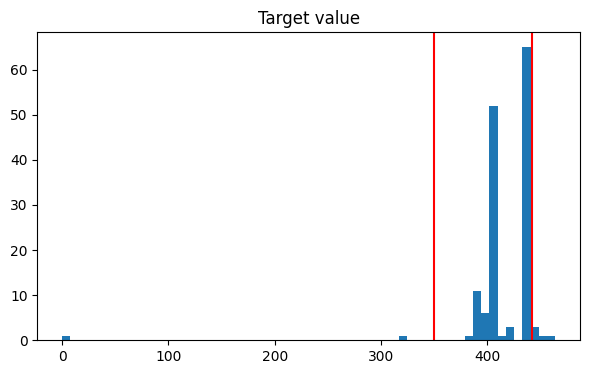

In [6]:
# Delete anomalies
fig, ax = plt.subplots(figsize=(7, 4))
plt.hist(y, bins=60)
OUTLIER_BORDER = 350
OUTLIER_BORDER2 = 442
plt.axvline(OUTLIER_BORDER, c='red')
plt.axvline(OUTLIER_BORDER2, c='red')
plt.title('Target value')
plt.show()

In [7]:
indices = y[(y < OUTLIER_BORDER)].index
print(y[indices])
X.loc[indices]

12738    323.77
15876      0.00
Name: LIQ_RATE, dtype: float64


,DT_HOUR,EXT_DATA,PLIN,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
12738,2021-05-18 15:08:14,120,18.16,0.0,59.848,0.0,38.74,0.0,0.0,0.0,396.0,399.0,399.0,0.0
15876,2021-06-02 01:03:43,15,17.97,43.0,83.538,0.0,36.24,32.2,32.3,32.4,394.0,401.0,399.0,73.0


In [8]:
X = X[~X.index.isin(indices)]
y = y[~y.index.isin(indices)]

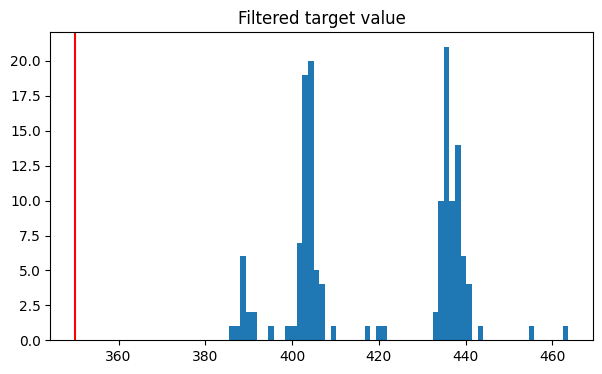

In [9]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.hist(y, bins=60)
plt.axvline(OUTLIER_BORDER, c='red')
plt.title('Filtered target value')
plt.show()

    Здесь сделаю небольшой комментарий: аномалии были удалены не потому, что аномалии плохо per se. Они были удалены, потому что не было найдено адекватного способа их предсказать: в 1 случае половина недавних измерений являются аномальными (нулевыми), а во 2 случае значения признаков, записанных примерно в то же время, находятся недалеко от их средних значений. Для детекции в проде случаев типа 1 можно попробовать смотреть на квантиль каждого из признаков и предупреждать, что предсказание может быть недостоверным.

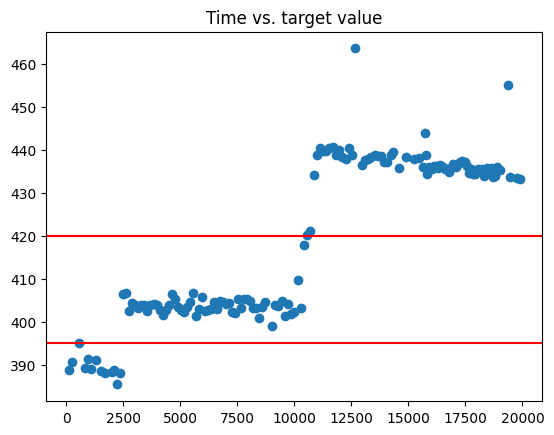

In [10]:
# Clusterize the data
# We could use some cool clusterization algorithm, but due to the 1-dimensionality of data the division
# is obvious & can be performed manually

plt.scatter(y.index, y)
T1, T2 = 395, 420
plt.axhline(T1, color='red')
plt.axhline(T2, color='red')
plt.title('Time vs. target value')
plt.show()

Внимание! Дальнейшее деление на train и test нужно для того, чтобы сделать тренировочным датасет наиболее разнообразным: хочется, чтобы мы легко находили общие закономерности, но не переобучались на частные случаи. Здесь не происходит data leak.

In [11]:
small = X[y < T1], y[y < T1]
medium = X[(y >= T1) & (y < T2)], y[(y >= T1) & (y < T2)]
large = X[y > T2], y[y > T2]


get_split = lambda data, i, test: data[i].iloc[: len(data[i]) // 4] if test else data[i].iloc[len(data[i]) // 4:]


X_train = pd.concat([get_split(d, 0, False) for d in (small, medium, large)])
y_train = pd.concat([get_split(d, 1, False) for d in (small, medium, large)])
X_test = pd.concat([get_split(d, 0, True) for d in (small, medium, large)])
y_test = pd.concat([get_split(d, 1, True) for d in (small, medium, large)])

**Проверим пункт 1**

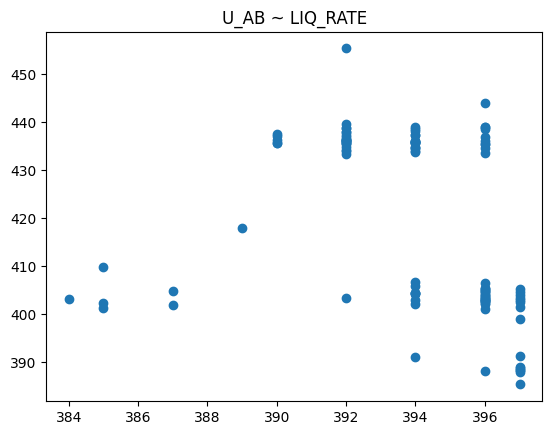

In [12]:
plt.title('U_AB ~ LIQ_RATE')
plt.scatter(X_train['U_AB'], y_train)
plt.show()

In [13]:
X_train['U_AB'].corr(y_train)

-0.29880240368604777

Получили отрицательную корреляцию. Но тут у нас три кластера вместе, и мы можем получить что-то похожее на "парадокс" Симпсона:


![](simpson.png)

In [14]:
print(small[0]['U_AB'].corr(small[1]))
print(medium[0]['U_AB'].corr(medium[1]))
print(large[0]['U_AB'].corr(large[1]))

-0.41835912532248054
-0.22069071193395642
0.14044044553635748


Видимо, данные зависят от других признаков сильно больше, поэтому заметить искомую корреляцию не удалось.

Попробуем несколько распространенных моделей: линейную регрессию, градиентный бустинг. Далее будем рассматривать данные поближе :)

In [15]:
import catboost
from sklearn.metrics import r2_score
reg_cb = catboost.CatBoostRegressor(verbose=0)

In [16]:
X_train = X_train.drop(['DT_HOUR', 'EXT_DATA', 'PED_T'], axis=1, errors='ignore')
X_test = X_test.drop(['DT_HOUR', 'EXT_DATA', 'PED_T'], axis=1, errors='ignore')

In [17]:
reg_cb.fit(X_train, y_train)
r2_score(y_test, reg_cb.predict(X_test))

0.940853003665254

In [18]:
from sklearn.linear_model import Ridge
reg_lr = Ridge()
reg_lr.fit(X_train, y_train)
r2_score(y_test, reg_lr.predict(X_test))

0.935358468792172

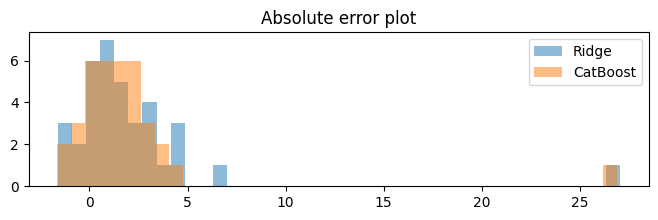

In [19]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.hist(y_test - reg_lr.predict(X_test), bins=40, alpha=0.5, label='Ridge')
ax.hist(y_test - reg_cb.predict(X_test), bins=40, alpha=0.5, label='CatBoost')
plt.title('Absolute error plot')
plt.legend()
plt.show()

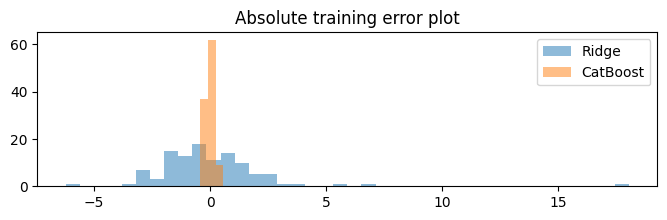

In [20]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.hist(y_train - reg_lr.predict(X_train), bins=40, alpha=0.5, label='Ridge')
ax.hist(y_train - reg_cb.predict(X_train), bins=3, alpha=0.5, label='CatBoost')
plt.title('Absolute training error plot')
plt.legend()
plt.show()

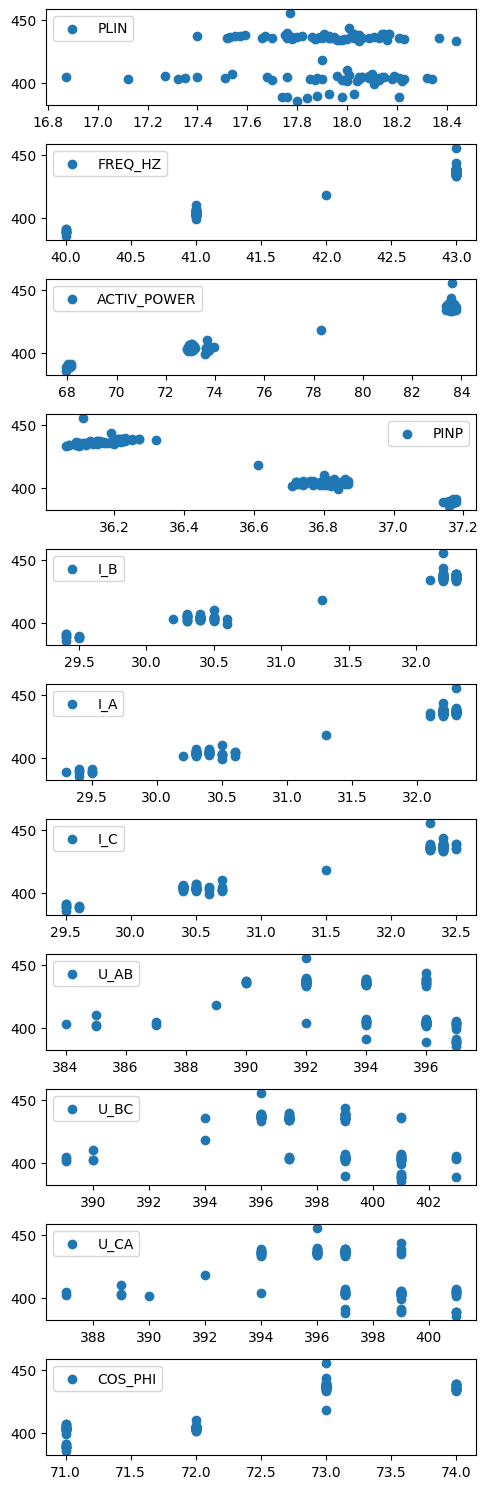

In [21]:
def marginal(X_train, y_train, name, ax):
    ax.scatter(X_train[name], y_train, label=name)

fig, ax = plt.subplots(len(X_train.columns), figsize=(5, 15))
for i, name in enumerate(X_train.columns):
    marginal(X_train, y_train, name, ax[i])
    ax[i].legend()
    
plt.tight_layout()
plt.show()

Те признаки, где хорошо прослеживается зависимость, выглядят как будто линейно влияющими на таргет. Но возможно, что у них есть какие-то нетривиальные взаимные зависимости. Так как наша задача имеет физическую природу, можно сделать допущение, что какие-то простые мономы от признаков могут фигурировать в формуле, приближающей таргет.

In [22]:
def add_monomials(X):
    X_new = X.copy()
    for col1 in range(len(X.columns)):
        for col2 in range(col1 + 1):
            X_new[X.columns[col1] + X.columns[col2]] = X_new[X.columns[col1]] * X_new[X.columns[col2]]
            X_new[X.columns[col1] + X.columns[col2] + 'd'] = X_new[X.columns[col1]] / X_new[X.columns[col2]]
    return X_new

X_train_new = add_monomials(X_train)
X_test_new = add_monomials(X_test)
X_test_new.sample(5)

/var/folders/j4/tx0ll0_166s04rpqz0yx_35m0000gn/T/ipykernel_35553/2061216441.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_new[X.columns[col1] + X.columns[col2] + 'd'] = X_new[X.columns[col1]] / X_new[X.columns[col2]]
/var/folders/j4/tx0ll0_166s04rpqz0yx_35m0000gn/T/ipykernel_35553/2061216441.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_new[X.columns[col1] + X.columns[col2]] = X_new[X.columns[col1]] * X_new[X.columns[col2]]
/var/folders/j4/tx0ll0_166s04rpqz0yx_35m0000gn/T/ipykernel_35553/2061216441.py:6: Performa

,PLIN,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,...,COS_PHII_C,COS_PHII_Cd,COS_PHIU_AB,COS_PHIU_ABd,COS_PHIU_BC,COS_PHIU_BCd,COS_PHIU_CA,COS_PHIU_CAd,COS_PHICOS_PHI,COS_PHICOS_PHId
11111,18.03,43.0,83.568,36.37,32.2,32.3,32.5,396.0,397.0,397.0,...,2405.0,2.276923,29304.0,0.186869,29378.0,0.186398,29378.0,0.186398,5476.0,1.0
584,17.48,40.0,68.000,37.19,29.5,29.5,29.6,396.0,401.0,401.0,...,2101.6,2.398649,28116.0,0.179293,28471.0,0.177057,28471.0,0.177057,5041.0,1.0
2900,17.62,41.0,72.635,36.96,30.3,30.3,30.4,396.0,401.0,399.0,...,2188.8,2.368421,28512.0,0.181818,28872.0,0.179551,28728.0,0.180451,5184.0,1.0
12962,18.53,43.0,83.405,36.30,32.3,32.3,32.4,396.0,399.0,399.0,...,2397.6,2.283951,29304.0,0.186869,29526.0,0.185464,29526.0,0.185464,5476.0,1.0
12244,17.87,43.0,83.614,36.27,32.3,32.2,32.5,392.0,399.0,396.0,...,2405.0,2.276923,29008.0,0.188776,29526.0,0.185464,29304.0,0.186869,5476.0,1.0


In [23]:
reg_lr = Ridge()
reg_lr.fit(X_train_new, y_train)
r2_score(y_test, reg_lr.predict(X_test_new))

0.9333859901868589

Эх, переобучились :(

**Но давайте вспомним про тот график ошибок**

Заметим, что ошибки почти все смещены вправо. Также заметим, что мы вырезали для трейна начала "кластеров", а для теста "конец". У нас есть дополнительные параметры кроме LIQ_RATE, которые измеряются редко, и они характеризуют **сырье**. Вдруг оно изменялось постепенно? Построим остальные параметры по времени.

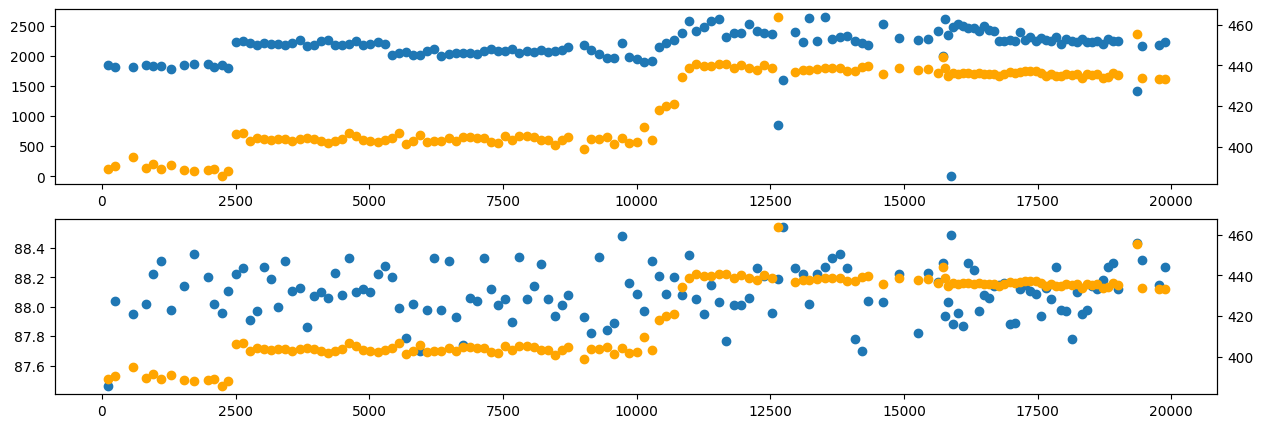

In [24]:
side_targets = df[~df['QGAS'].isna()]
fig, ax = plt.subplots(2, figsize=(15, 5))
ax[0].scatter(side_targets.index, side_targets.QGAS)
ax_new = ax[0].twinx()
ax_new.scatter(side_targets[side_targets.LIQ_RATE > 350].index, side_targets[side_targets.LIQ_RATE > 350].LIQ_RATE, c='orange')

ax[1].scatter(side_targets.index, side_targets.WATER_CUT)
ax_new_2 = ax[1].twinx()
ax_new_2.scatter(side_targets[side_targets.LIQ_RATE > 350].index, side_targets[side_targets.LIQ_RATE > 350].LIQ_RATE, c='orange')

plt.show()

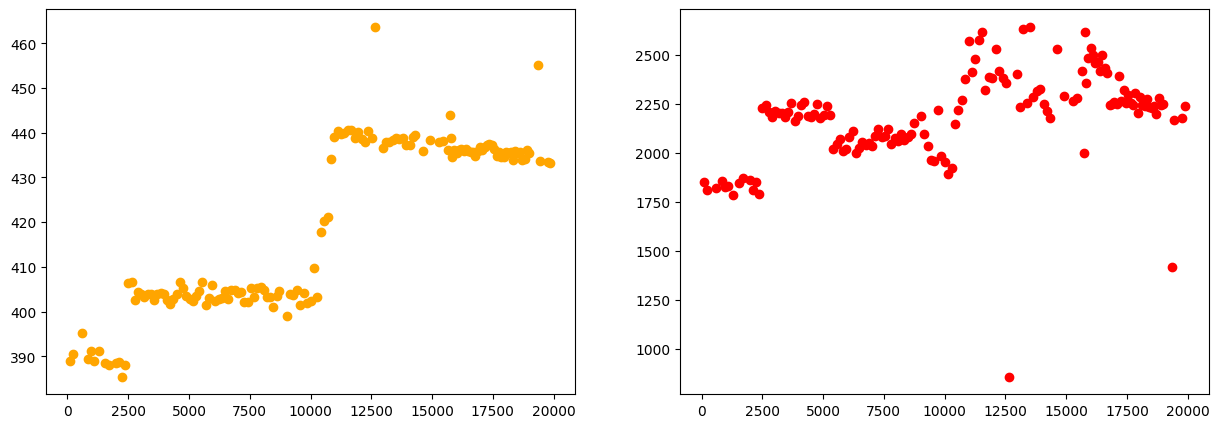

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(side_targets[side_targets.LIQ_RATE > 350].index, side_targets[side_targets.LIQ_RATE > 350].LIQ_RATE, c='orange')
ax[1].scatter(side_targets[side_targets.LIQ_RATE > 350].index, side_targets[side_targets.LIQ_RATE > 350].QGAS, c='red')
plt.show()

Вроде ничего интересного не нашли. Но все еще интересно понять, есть ли какие-то зависимости внутри кластера. Возьмем large.

/var/folders/j4/tx0ll0_166s04rpqz0yx_35m0000gn/T/ipykernel_35553/2061216441.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_new[X.columns[col1] + X.columns[col2] + 'd'] = X_new[X.columns[col1]] / X_new[X.columns[col2]]
/var/folders/j4/tx0ll0_166s04rpqz0yx_35m0000gn/T/ipykernel_35553/2061216441.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_new[X.columns[col1] + X.columns[col2]] = X_new[X.columns[col1]] * X_new[X.columns[col2]]
/var/folders/j4/tx0ll0_166s04rpqz0yx_35m0000gn/T/ipykernel_35553/2061216441.py:6: Performa

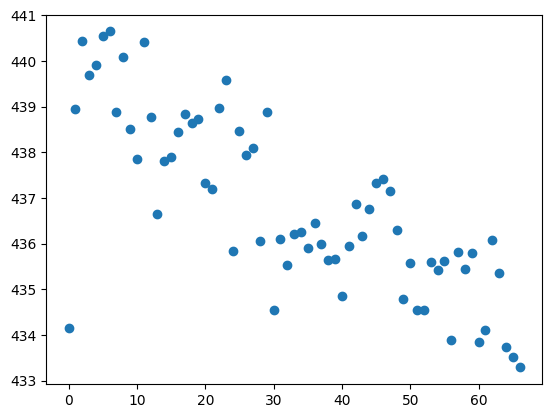

In [26]:
large_clip = large[1][(large[1] > 430) & (large[1] < 442)]
large_clip_train = large[0][(large[1] > 430) & (large[1] < 442)]
large_clip_train = large_clip_train.drop(['DT_HOUR', 'EXT_DATA', 'PED_T'], axis=1, errors='ignore')

large_clip_train_monomials = add_monomials(large_clip_train)
plt.scatter(range(len(large_clip)), large_clip)
plt.show()

In [27]:
res = []
import numpy as np
for i in large_clip_train_monomials.columns:
    if -1 < large_clip.corr(large_clip_train_monomials[i]) < 1:
        res.append((large_clip.corr(large_clip_train_monomials[i]) , i))
res.sort()
print(res[:2])
print(res[-2:])

[(-0.5112188078368441, 'I_BPINPd'), (-0.45493503070981584, 'I_APINPd')]
[(0.778406817516145, 'PINPFREQ_HZ'), (0.8262300393488661, 'PINPACTIV_POWER')]


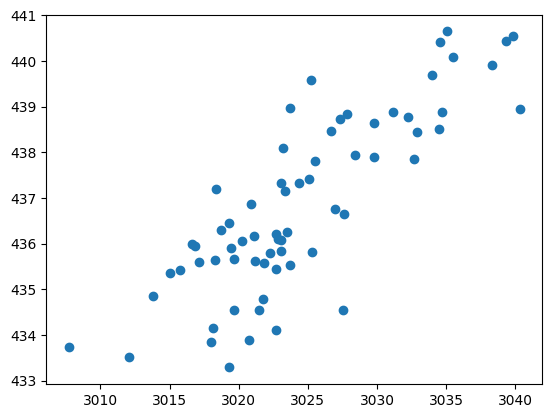

In [28]:
plt.scatter(large_clip_train_monomials.PINPACTIV_POWER, large_clip)
plt.show()

Можно попробовать оставить вот эти показатели в линейной регрессии. Возможно, будем меньше переобучаться. Давайте еще все поскейлим.

In [29]:
from sklearn.preprocessing import StandardScaler
best_f = [i[1] for i in res[:2] + res[-2:]]
FEATURES_ok = list(FEATURES)
for i in ['DT_HOUR', 'EXT_DATA', 'PED_T']:
    FEATURES_ok.remove(i)
X_train_new2 = X_train_new[np.unique(list(FEATURES_ok) + list(best_f))]
X_test_new2 = X_test_new[np.unique(list(FEATURES_ok) + list(best_f))]
scalerX = StandardScaler()
X_train_new2 = scalerX.fit_transform(X_train_new2)
X_test_new2 = scalerX.transform(X_test_new2)   
scalery = StandardScaler()
y_train2 = scalery.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test2 = scalery.fit_transform(y_test.to_numpy().reshape(-1, 1))
reg_lr = Ridge()
reg_lr.fit(X_train_new2, y_train2)
r2_score(y_test2, reg_lr.predict(X_test_new2))

0.9444648051213235

О, класс! Тогда сделаем и кросс-валидацию.

In [30]:
from sklearn.linear_model import RidgeCV
reg_lr = RidgeCV(alphas = 2 ** np.arange(0, 20), cv=3)
reg_lr.fit(X_train_new2, y_train2)
r2_score(y_test2, reg_lr.predict(X_test_new2))

0.9447892675245614

In [31]:
reg_cb.fit(X_train_new2, y_train2)
r2_score(y_test2, reg_cb.predict(X_test_new2))

0.9438589392520912

Проблема Catboost в том, что регрессоры **не могут предсказать значения, выходящие за рамки минимума-максимума** в обучающей выборке (это известная проблема любой древовидной модели, в листьях которой написаны константы). Кроме того, при маленьком количестве данных деревья плохо приближают даже простые функции. Поэтому, так как многие зависимости у нас кусочно-линейные, давайте построим градиентный бустинг с линейной регрессией в каждом листе.

In [32]:
! pip3 install linear-tree

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [33]:
from lineartree import LinearBoostRegressor

reg_tlr = LinearBoostRegressor(base_estimator=Ridge(), max_depth=4, n_estimators=5)
reg_tlr.fit(X_train_new2, y_train2)
r2_score(y_test2, reg_tlr.predict(X_test_new2))

0.9449802656830918

In [34]:
X_train_new2[0]

array([-1.72539528, -1.37346797, -1.73285205, -1.77702307, -1.78004082,
       -1.79547521, -1.79406148, -1.77685163,  1.85158243, -1.72325339,
       -1.6732469 ,  0.42961899,  1.08126734,  1.00737911,  0.01927   ])

Что-то, похожее на предиктор, которую можно использовать при заданных ограничениях:

Тут еще при получении данных, равных 0, указывается последнее значение, полученное для полных данных. Иначе получаем точно неверное предсказание из-за зануления коэффициентов. Можно пойти дальше и попробовать делать это, если какое-то значение отклоняется больше чем на X стандартных отклонений от среднего.

In [50]:
class LiqRatePredictor:
        
    FEATURES = np.unique(list(FEATURES_ok) + list(best_f))
    FEATURES_base = list(FEATURES_ok)
    
    def __init__(self, model, scalerX, scalery):
        self.scalerX = scalerX
        self.scalery = scalery
        self.model = model
        self.last_pred = None
        self.recent_data = pd.Series(np.nan, index=self.FEATURES_base)
        self.recent_data_full = pd.Series(np.nan, index=self.FEATURES)
        
    def __add_features(self):
        self.recent_data_full = self.recent_data.copy()
        self.recent_data_full['I_BPINPd'] =  self.recent_data['I_B'] /  self.recent_data['PINP']
        self.recent_data_full['I_APINPd'] =  self.recent_data['I_A'] /  self.recent_data['PINP']
        self.recent_data_full['PINPFREQ_HZ'] =  self.recent_data['FREQ_HZ'] *  self.recent_data['PINP']
        self.recent_data_full['PINPACTIV_POWER'] =  self.recent_data['ACTIV_POWER'] *  self.recent_data['PINP']

        
    def update(self, measurement):
        measurement = measurement[self.FEATURES_base]
        self.recent_data[~measurement.isna()] = measurement[~measurement.isna()]
    
    def predict(self):
        if self.recent_data.isna().sum():
            return None
        self.__add_features()
        pred = self.model.predict(
            self.scalerX.transform(
                self.recent_data_full[self.FEATURES].to_numpy().reshape(1, -1)
            )
        )
        pred = self.scalery.inverse_transform(pred)
        if any(self.recent_data == 0): # corrupted data? 
            return self.last_pred
        self.last_pred = pred
        return pred

**Пример**

In [51]:
predictor = LiqRatePredictor(reg_tlr, scalerX, scalery)
import warnings
warnings.simplefilter(action='ignore')
measurements = df.loc[:, LiqRatePredictor.FEATURES_base]
res = []
for idx, measurement in measurements.iterrows():
    
    predictor.update(measurement)
    pred = predictor.predict()
    
    if idx < 100: print('Measurement after data-point', idx, ':', pred)
    if pred is not None:
        res.append(pred[0])


Measurement after data-point 0 : None
Measurement after data-point 1 : None
Measurement after data-point 2 : [[387.812468]]
Measurement after data-point 3 : [[387.80707885]]
Measurement after data-point 4 : [[386.69859471]]
Measurement after data-point 5 : [[386.39984586]]
Measurement after data-point 6 : [[386.40415654]]
Measurement after data-point 7 : [[386.5059561]]
Measurement after data-point 8 : [[387.18488179]]
Measurement after data-point 9 : [[387.18057015]]
Measurement after data-point 10 : [[387.10139271]]
Measurement after data-point 11 : [[387.10252798]]
Measurement after data-point 12 : [[387.10791793]]
Measurement after data-point 13 : [[387.12135555]]
Measurement after data-point 14 : [[387.77739718]]
Measurement after data-point 15 : [[387.76122733]]
Measurement after data-point 16 : [[387.3766512]]
Measurement after data-point 17 : [[387.32098018]]
Measurement after data-point 18 : [[387.33715003]]
Measurement after data-point 19 : [[387.21272834]]
Measurement after 

Text(0.5, 1.0, 'Preds with last value optimization')

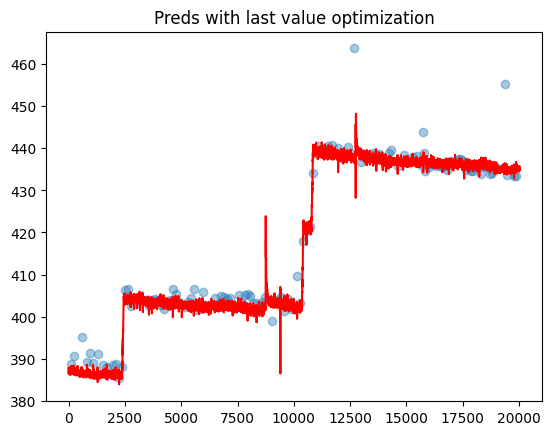

In [52]:
plt.scatter(X.index, y, label='Real', alpha=0.4)
plt.plot(df.index[2:], res, label='Predicted', c='red')
plt.title('Preds with last value optimization')

Мы все еще не можем научиться предсказывать те самые два выброса. Если их удалить:

In [45]:
y_train1 = y_train[y_train < 442]
X_train1 = X_train_new[y_train < 442]
y_test1 = y_test[y_test < 442]
X_test1 = X_test_new[y_test < 442]

X_train_new3 = X_train1[np.unique(list(FEATURES_ok) + list(best_f))]
X_test_new3 = X_test1[np.unique(list(FEATURES_ok) + list(best_f))]

scalerX = StandardScaler()
X_train_new3 = scalerX.fit_transform(X_train_new3)
X_test_new3 = scalerX.transform(X_test_new3)   
scalery = StandardScaler()

y_train3 = scalery.fit_transform(y_train1.to_numpy().reshape(-1, 1))
y_test3 = scalery.fit_transform(y_test1.to_numpy().reshape(-1, 1))
reg_lr = Ridge()
reg_lr.fit(X_train_new3, y_train3)
r2_score(y_test3, reg_lr.predict(X_test_new3))

0.9886117632249187

In [47]:
reg_lr2 = RidgeCV(alphas = 2 ** np.arange(0, 20), cv=3)
reg_lr2.fit(X_train_new3, y_train3)
r2_score(y_test3, reg_lr2.predict(X_test_new3))

0.9818113668922681

In [48]:
reg_cb.fit(X_train_new3, y_train3)
r2_score(y_test3, reg_cb.predict(X_test_new3))

0.986638232010376

In [41]:
reg_tlr = LinearBoostRegressor(base_estimator=Ridge())
reg_tlr.fit(X_train_new3, y_train3)
r2_score(y_test3, reg_tlr.predict(X_test_new3))

0.9872764339237444

In [53]:
predictor = LiqRatePredictor(reg_lr, scalerX, scalery)
import warnings
warnings.simplefilter(action='ignore')
measurements = df.loc[:, LiqRatePredictor.FEATURES_base]
res = []
for idx, measurement in measurements.iterrows():
    
    predictor.update(measurement)
    pred = predictor.predict()
    
    if idx < 100: print('Measurement after data-point', idx, ':', pred)
    if pred is not None:
        res.append(pred[0])


Measurement after data-point 0 : None
Measurement after data-point 1 : None
Measurement after data-point 2 : [[387.1052092]]
Measurement after data-point 3 : [[387.1006557]]
Measurement after data-point 4 : [[386.48783567]]
Measurement after data-point 5 : [[385.82146573]]
Measurement after data-point 6 : [[385.8251074]]
Measurement after data-point 7 : [[385.8813868]]
Measurement after data-point 8 : [[386.81307458]]
Measurement after data-point 9 : [[386.80943122]]
Measurement after data-point 10 : [[386.76565836]]
Measurement after data-point 11 : [[386.59241049]]
Measurement after data-point 12 : [[386.59696538]]
Measurement after data-point 13 : [[386.94714908]]
Measurement after data-point 14 : [[387.30983849]]
Measurement after data-point 15 : [[387.29617381]]
Measurement after data-point 16 : [[387.08356277]]
Measurement after data-point 17 : [[386.45993034]]
Measurement after data-point 18 : [[386.47359503]]
Measurement after data-point 19 : [[386.4048091]]
Measurement after d

Text(0.5, 1.0, 'Preds with last value optimization')

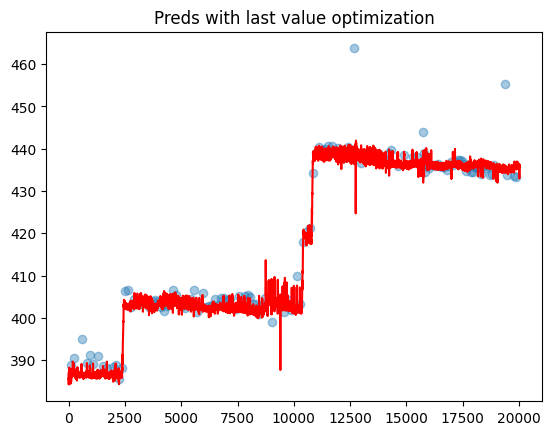

In [43]:
plt.scatter(X.index, y, label='Real', alpha=0.4)
plt.plot(df.index[2:], res, label='Predicted', c='red')
plt.title('Preds with last value optimization')

Text(0.5, 1.0, 'Preds with last value optimization, zoom-in')

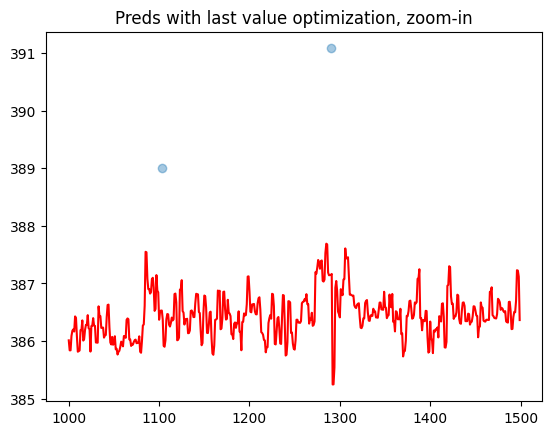

In [60]:
plt.scatter(y.loc[10000:12000].index, y.loc[1000:1500], label='Real', alpha=0.4)
plt.plot(df.index[10000:12000], res[1000-2:1500-2], label='Predicted', c='red')
plt.title('Preds with last value optimization, zoom-in')

Для тестирования обучимся на всем датасете: **Это финальная модель**

In [54]:
reg_tlr = RidgeCV()
X_train_new3 = X_train1[np.unique(list(FEATURES_ok) + list(best_f))]
X_test_new3 = X_test1[np.unique(list(FEATURES_ok) + list(best_f))]

X3 = pd.concat([X_train_new3, X_test_new3], axis=0) 
Y3 = np.concatenate([y_train3, y_test3], axis=0) 

scalerX = StandardScaler()
scalerY = StandardScaler()

X3 = scalerX.fit_transform(X3)
Y3 = scalerY.fit_transform(Y3)   

reg_tlr.fit(X3, Y3)
r2_score(Y3, reg_tlr.predict(X3))

0.9922240396534924